<a href="https://colab.research.google.com/github/JCSR2022/Alura_Data_Science/blob/main/Learning_to_Classify_Data_with_ML/Clasificacion_primeros_pasos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificación: Primeros pasos**

En este proyecto, analizaremos datos de una campaña de marketing para la adhesión a inversiones. El objetivo es utilizar la información de los datos para predecir si los clientes de un banco invertirán su dinero o no.  

Esta predicción se realizará mediante **machine learning**, y este notebook contendrá los pasos para obtener un modelo capaz de hacer dichas predicciones, desde la **lectura**, **análisis exploratorio**, **separación** y **transformación** de los datos, hasta el **ajuste**, **evaluación** y **comparación** de modelos de clasificación.

# 0. Librerias



In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import pickle

#https://scikit-learn.org/stable/index.html
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# 1. Análisis exploratorio

## Realizando la lectura de los datos

Podemos leer los datos utilizando la biblioteca `pandas`. Por esta razón, importaremos la biblioteca con el comando `import pandas as pd`.  

Dado que el archivo de datos está en formato *csv*, realizaremos la lectura con la función [`read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html).

In [4]:
import pandas as pd

In [5]:
#https://github.com/JCSR2022/Alura_Data_Science/blob/main/Learning_to_Classify_Data_with_ML/marketing_inversiones.csv
git_raw = 'https://raw.githubusercontent.com/'
url_github = 'JCSR2022/Alura_Data_Science/main/Learning_to_Classify_Data_with_ML/marketing_inversiones.csv'
datos = pd.read_csv(git_raw + url_github)


Para crear modelos de clasificación, necesitamos utilizar datos de calidad, sin inconsistencias y sin datos faltantes. Verificaremos si existen datos nulos y el tipo de datos de cada columna en la base de datos utilizando el método [`info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html).

In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   edad                  1268 non-null   int64 
 1   estado_civil          1268 non-null   object
 2   escolaridad           1268 non-null   object
 3   default               1268 non-null   object
 4   saldo                 1268 non-null   int64 
 5   prestatario           1268 non-null   object
 6   ultimo_contacto       1268 non-null   int64 
 7   ct_contactos          1268 non-null   int64 
 8   adherencia_inversion  1268 non-null   object
dtypes: int64(4), object(5)
memory usage: 89.3+ KB


In [7]:
datos.sample(5)

,edad,estado_civil,escolaridad,default,saldo,prestatario,ultimo_contacto,ct_contactos,adherencia_inversion
1127,41,casado (a),secundaria,no,1066,no,109,3,si
99,34,soltero (a),superior,no,415,no,123,1,no
365,44,divorciado (a),secundaria,no,14,no,167,1,si
36,40,casado (a),superior,no,1584,no,661,1,no
129,21,soltero (a),secundaria,no,2488,no,258,6,si


In [8]:
# for col in datos.columns:
#   if datos[col].dtype == 'object':
#     print(f"{col}:{list(datos[col].unique())}" )

for col in datos.select_dtypes(include=['object']):
  print(f"{col}:{list(datos[col].unique())}" )

estado_civil:['casado (a)', 'soltero (a)', 'divorciado (a)']
escolaridad:['superior', 'secundaria', 'primaria']
default:['no', 'si']
prestatario:['no', 'si']
adherencia_inversion:['si', 'no']


In [9]:
datos.describe()

,edad,saldo,ultimo_contacto,ct_contactos
count,1268.000000,1268.000000,1268.000000,1268.000000
mean,41.376972,1443.426656,367.574921,2.715300
std,11.383805,2690.406767,347.969723,2.885642
min,19.000000,-1206.000000,5.000000,1.000000
25%,33.000000,91.250000,134.000000,1.000000
50%,39.000000,491.500000,251.000000,2.000000
75%,49.000000,1623.500000,488.250000,3.000000
max,87.000000,27069.000000,3025.000000,32.000000


In [10]:
#datos[[ col for col in  datos.columns  if datos[col].dtype != 'object']]
datos.select_dtypes(include=['number'])

,edad,saldo,ultimo_contacto,ct_contactos
0,45,242,587,1
1,42,1289,250,4
2,23,363,16,18
3,58,1382,700,1
4,50,3357,239,4
...,...,...,...,...
1263,52,83,1223,6
1264,35,5958,215,1
1265,30,-477,1532,2
1266,42,2187,525,3



## 📊 Descripción del Dataset

El conjunto de datos `marketing_inversiones.csv` contiene información detallada sobre el perfil de los clientes y su comportamiento histórico frente a campañas bancarias. Consta de **1,268 registros** y **9 columnas**.

| Columna | Tipo de Dato | Descripción |
| --- | --- | --- |
| **edad** | `int64` | Edad del cliente. |
| **estado_civil** | `object` | Estado civil del cliente (Soltero, Casado, Divorciado). |
| **escolaridad** | `object` | Nivel educativo alcanzado. |
| **default** | `object` | Indica si el cliente tiene deudas pendientes. **"Sí"**: No pagó (mal pagador). **"No"**: Cliente al día (buen pagador). |
| **saldo** | `int64` | Saldo total disponible en la cuenta bancaria del cliente. |
| **prestatario** | `object` | Indica si el cliente ha solicitado o tiene préstamos vigentes con el banco. |
| **ultimo_contacto** | `int64` | Cantidad de días transcurridos desde la última vez que se contactó al cliente. |
| **ct_contactos** | `int64` | Número total de veces que se ha contactado a esta persona durante la campaña. |
| **adherencia_inversion** | `object` | **Variable Objetivo (Target).** Indica si el cliente aceptó unirse a la cartera de inversión previa. |

---

### Notas sobre los datos:

* **Limpieza:** El dataset no presenta valores nulos (1268 non-null en todas las columnas).
* **Variables Categóricas:** Columnas como `estado_civil`, `escolaridad`, y `default` requieren transformación (como *One-Hot Encoding* o *Label Encoding*) antes de ser procesadas por los modelos de Scikit-Learn.
* **Interpretación de Negocio:** La columna `default` es un indicador crítico de riesgo crediticio para la segmentación de recomendaciones.

## Explorando los datos

Una etapa muy importante en proyectos de *machine learning* es la exploración y comprensión de los datos, conocida como **análisis exploratorio**. Podemos utilizar gráficos para verificar qué información contiene cada una de las columnas de la base de datos, así como identificar inconsistencias y patrones que puedan existir.  

Exploraremos cada una de las columnas de la base de datos utilizando la biblioteca `plotly`. Comenzaremos con las variables categóricas y luego analizaremos las variables numéricas.

### Variables categóricas

In [11]:
import plotly.express as px
import plotly.io as pio

In [12]:
def plot_categorica_proporcional(df, col, titulo=None,MI_ESTILO = "plotly_white" ):
    # Calculamos la frecuencia y el porcentaje
    counts = df[col].value_counts().reset_index()
    counts.columns = [col, 'cantidad']

    # Calculamos el porcentaje para mostrarlo en el texto
    total = counts['cantidad'].sum()
    counts['porcentaje'] = (counts['cantidad'] / total * 100).round(2).astype(str) + '%'

    # Creamos la gráfica de barras (mejor que histograma para mostrar etiquetas de texto)
    fig = px.bar(counts,
                 x=col,
                 y='cantidad',
                 text='porcentaje', # Aquí activamos los porcentajes sobre las barras
                 title=titulo if titulo else f"Distribución de: {col}",
                 #text_auto=True, # Esto muestra los valores sobre las barras
                 template=MI_ESTILO)

    # Configuración de tamaño (8,5 en pulgadas aprox es 800x500 px)
    # Ajustamos etiquetas y diseño
    fig.update_layout(
        width=800,
        height=500,
        xaxis_title=col.replace('_', ' ').capitalize(),
        yaxis_title="Cantidad de Clientes",
        font=dict(size=12),
        title_x=0.5 # Centrar el título
    )

    # Posicionamos el texto del porcentaje arriba de las barras
    fig.update_traces(textposition='outside')

    return fig

plot_categorica_proporcional(datos, 'adherencia_inversion').show()

In [13]:
#px.histogram(datos, x='estado_civil', color='adherencia_inversion')

def graficar_analisis_bivariado(df, col, target='adherencia_inversion',MI_ESTILO = "plotly_white"):
    """
    Genera histogramas comparativos para la columna  con respecto a la variable objetivo.
    """

    # Creamos el histograma comparativo
    fig = px.histogram(
        df,
        x=col,
        color=target,
        barmode='group',        # Barras agrupadas (una al lado de la otra)
        text_auto='.2s',        # Muestra el conteo sobre las barras de forma compacta
        template=MI_ESTILO,     # Usamos el estilo definido previamente
        title=f"Impacto de {col.replace('_', ' ').capitalize()} en la Adherencia"
    )

    # Ajustamos el tamaño (8,5 -> 800x500 px) y etiquetas
    fig.update_layout(
        width=800,
        height=500,
        xaxis_title=col.replace('_', ' ').capitalize(),
        yaxis_title="Cantidad de Clientes",
        legend_title=target,
        title_x=0.5
    )

    return fig


columnas_interes = ['estado_civil', 'escolaridad', 'default', 'prestatario']
for col in columnas_interes:
  graficar_analisis_bivariado(datos, col).show()

### Variables numéricas

In [14]:
px.box(datos, x='edad', color='adherencia_inversion',orientation='h')

In [15]:
def plot_box_plot(df, col, target='adherencia_inversion', titulo=None, MI_ESTILO="plotly_white"):
    """
    Genera un Box Plot para una variable numérica,
    segmentada por la variable objetivo para comparar distribuciones.
    """
    # Creamos el box plot
    # Usamos 'color' para separar quiénes invirtieron y quiénes no
    fig = px.box(
        df,
        y=col,
        x=target,
        color=target,
        #points="all",          # Muestra todos los puntos (opcional, ayuda a ver la densidad)
        #notched=True,          # Añade una muesca en la mediana para ver intervalos de confianza
        title=titulo if titulo else f"Distribución de {col.replace('_', ' ').capitalize()} vs Adherencia",
        template=MI_ESTILO
    )

    # Configuración de tamaño (8,5 -> 800x500 px) y etiquetas
    fig.update_layout(
        width=800,
        height=500,
        xaxis_title="¿Se adhirió a la inversión?",
        yaxis_title=col.replace('_', ' ').capitalize(),
        showlegend=False,      # Ocultamos leyenda porque el eje X ya lo indica
        title_x=0.5
    )

    return fig

for col in datos.select_dtypes(include=['int64']):
  plot_box_plot(datos, col).show()
#plot_box_plot(datos, 'edad').show()


In [16]:
def plot_distributions(df, col, title=None, xlabels=None, bins=100, MI_ESTILO="plotly_white"):
    """
    Genera un histograma para variables numéricas con una curva de densidad
    marginal (KDE) y un rug plot en la base.
    """

    # Creamos el histograma
    fig = px.histogram(
        df,
        x=col,
        nbins=bins,              # Control de la granularidad
        marginal="rug",          # Añade pequeñas líneas en la base para ver la densidad real
        opacity=0.7,
        title=title if title else f"Distribución de {col.replace('_', ' ').capitalize()}",
        template=MI_ESTILO,
        color_discrete_sequence=['#636EFA'] # Un azul profesional
    )

    # Configuración de tamaño (8,5 -> 800x500 px) y etiquetas
    fig.update_layout(
        width=800,
        height=500,
        xaxis_title=xlabels if xlabels else col.replace('_', ' ').capitalize(),
        yaxis_title="Frecuencia",
        title_x=0.5,
        bargap=0.05 # Un pequeño espacio entre barras para que se vea más limpio
    )

    return fig

for col in datos.select_dtypes(include=['int64']):
  plot_distributions(datos, col, bins=100, xlabels=col).show()


## Guardar graficas

In [17]:
# Generas la figura con tu función
fig_saldo = plot_distributions(datos, 'saldo', bins=100, xlabels="Saldo en Cuenta (USD)")

# Guardas como HTML
#fig_saldo.write_html("fig_saldo.html")
fig_saldo.write_html("fig_saldo_light.html", include_plotlyjs='cdn')

# 2. Tranformación de los datos

## Variables explicativas y variable de respuesta

Para realizar la predicción de los valores con un modelo de aprendizaje automático, necesitamos separar la variable objetivo de las variables explicativas. La variable **y** representa lo que queremos predecir, mientras que **x** incluye todas las variables que se utilizarán para explicar el comportamiento de **y**.

In [18]:
X = datos.drop('adherencia_inversion', axis=1).copy()
y = datos['adherencia_inversion'].copy()

## Transformando las variables explicativas

Los algoritmos de aprendizaje automático no comprenden datos en formato de texto, por lo que debemos transformar los datos a un formato numérico para que el algoritmo pueda interpretar la información. Esta transformación debe realizarse de manera que no altere la información original del conjunto de datos, por lo que no basta con simplemente cambiar los valores a números aleatorios.

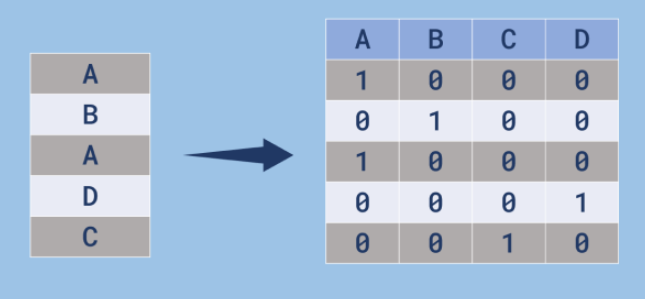

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

X = datos.drop('adherencia_inversion', axis=1).copy()

# Identificamos TODAS las categóricas
features_to_encode = X.select_dtypes(include=['object']).columns.tolist()
one_hot_encoder = ColumnTransformer(transformers=[('onehot', OneHotEncoder(drop='if_binary', sparse_output=False), features_to_encode)],remainder='passthrough')

# Al usar fit_transform, Scikit-Learn devuelve un array de NumPy
X_encoded = one_hot_encoder.fit_transform(X)

# Para recuperar los nombres de las columnas y volver a tener un DataFrame:
columnas_finales = one_hot_encoder.get_feature_names_out()
X_encoded_df = pd.DataFrame(X_encoded, columns=columnas_finales)

X_encoded_df.head()

,onehot__estado_civil_casado (a),onehot__estado_civil_divorciado (a),onehot__estado_civil_soltero (a),onehot__escolaridad_primaria,onehot__escolaridad_secundaria,onehot__escolaridad_superior,onehot__default_si,onehot__prestatario_si,remainder__edad,remainder__saldo,remainder__ultimo_contacto,remainder__ct_contactos
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.0,242.0,587.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,42.0,1289.0,250.0,4.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,23.0,363.0,16.0,18.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,58.0,1382.0,700.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50.0,3357.0,239.0,4.0


In [20]:
X_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   onehot__estado_civil_casado (a)      1268 non-null   float64
 1   onehot__estado_civil_divorciado (a)  1268 non-null   float64
 2   onehot__estado_civil_soltero (a)     1268 non-null   float64
 3   onehot__escolaridad_primaria         1268 non-null   float64
 4   onehot__escolaridad_secundaria       1268 non-null   float64
 5   onehot__escolaridad_superior         1268 non-null   float64
 6   onehot__default_si                   1268 non-null   float64
 7   onehot__prestatario_si               1268 non-null   float64
 8   remainder__edad                      1268 non-null   float64
 9   remainder__saldo                     1268 non-null   float64
 10  remainder__ultimo_contacto           1268 non-null   float64
 11  remainder__ct_contactos       

## Transformando la variable respuesta

In [21]:
# # Diccionario de mapeo
# mapa = {'si': 1, 'no': 0}

# # Aplicamos la transformación
# datos['adherencia_inversion'] = datos['adherencia_inversion'].map(mapa)

# # Verificamos
# print(datos['adherencia_inversion'].value_counts())

Así como las variables explicativas, la variable objetivo también debe convertirse al formato numérico. Podemos representar una variable objetivo binaria como 0 o 1, donde 0 indica la ausencia de la característica de la variable y 1 representa su presencia.

In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

y_encoded

array([1, 1, 0, ..., 1, 1, 1])

# 3 Ajustando modelos

## Dividiendo los datos entre entrenamiento y prueba

Para comprender si el modelo realmente está aprendiendo de los datos, necesitamos hacer una separación de los datos entre entrenamiento y prueba. Los datos de **entrenamiento** se utilizan para ajustar el modelo, mientras que los datos de **prueba** sirven para verificar el aprendizaje del modelo en datos que no fueron utilizados en el momento del ajuste.

<a href="https://ibb.co/2749Chh3"><img src="https://i.ibb.co/Y7sC1QQB/train-test.png" alt="train-test" border="0"></a>

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded,train_size=.3,random_state=5,stratify=y_encoded)



## Modelo de referencia - Baseline

El modelo más simple de clasificar los datos es simplemente utilizar un algoritmo que asigna todas las clasificaciones a la clase que tiene mayor frecuencia. Este algoritmo sirve como un criterio de comparación para identificar si los otros modelos tienen un rendimiento mejor que la clasificación más simple posible.

In [24]:
from sklearn.dummy import DummyClassifier
"""
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
default=prior
“prior”: the predict method always returns the most frequent class label in the observed y argument passed to fit (like “most_frequent”). predict_proba always returns the empirical class distribution of y also known as the empirical class prior distribution.

“uniform”: generates predictions uniformly at random from the list of unique classes observed in y, i.e. each class has equal probability.
"""
dummy_classifier = DummyClassifier(strategy='uniform')
dummy_classifier.fit(X_train, y_train)
dummy_classifier.score(X_test, y_test)


0.5078828828828829

In [25]:
"""
default=prior
“prior”: the predict method always returns the most frequent class label in the observed y argument passed to fit (like “most_frequent”). predict_proba always returns the empirical class distribution of y also known as the empirical class prior distribution.
"""
dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, y_train)
dummy_classifier.score(X_test, y_test)



0.6036036036036037

## Árboles de Decisión

El modelo de árbol de decisión es muy utilizado debido a su alta **explicabilidad** y **procesamiento rápido**, manteniendo un rendimiento bastante interesante.

Se basa en decisiones simples tomadas por el algoritmo, separando los datos mediante comparaciones de **menor** y **mayor** en los valores de las columnas de la base de datos.

In [26]:
from sklearn.tree import DecisionTreeClassifier
"""
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py


"""

tree_classifier = DecisionTreeClassifier(random_state=5)
tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=5)

In [27]:
tree_classifier.score(X_test, y_test)

0.6666666666666666

In [28]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [29]:
valores_columnas = ['casado (a)',
                'divorciado (a)',
                'soltero (a)',
                'primaria',
                'secundaria',
                'superior',
                'default',
                'prestatario',
                'edad',
                'saldo',
                'ultimo_contacto',
                'ct_contactos']

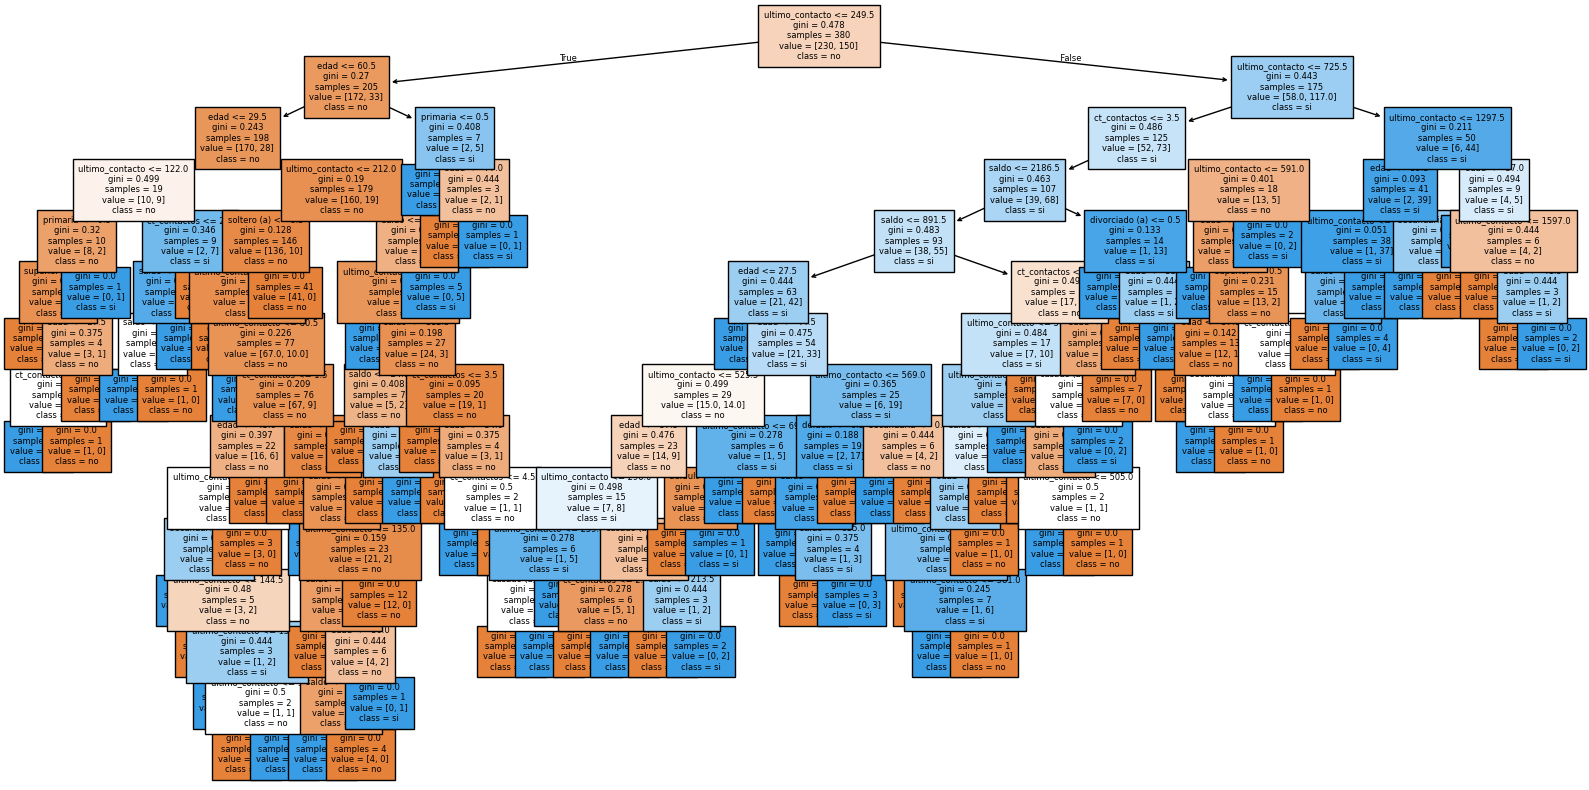

In [30]:
plt.figure(figsize=(20,10))
plot_tree(tree_classifier,
          feature_names=valores_columnas,
          filled=True,
          class_names=['no','si'],
          fontsize=6)
plt.show()

In [40]:
tree_classifier.score(X_train, y_train)

1.0

In [39]:
tree_classifier.score(X_test, y_test)

0.6666666666666666

In [42]:
modelo_arbol_3 = DecisionTreeClassifier(max_depth=3,random_state=5)
modelo_arbol_3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=5)

In [44]:
modelo_arbol_3.score(X_train, y_train)

0.7921052631578948

In [45]:
modelo_arbol_3.score(X_test, y_test)

0.6970720720720721

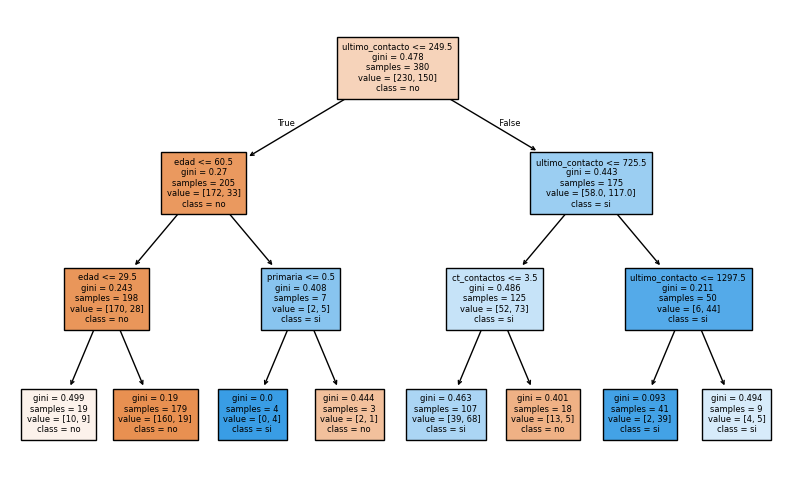

In [47]:
plt.figure(figsize=(10,6))
plot_tree(modelo_arbol_3,
          feature_names=valores_columnas,
          filled=True,
          class_names=['no','si'],
          fontsize=6)
plt.show()

# 4. Selección de modelos

## Normalizando los datos

Algunos algoritmos pueden asignar un mayor peso a los valores de las variables debido a la escala de los valores y no por la importancia de la clasificación de la variable objetivo. Por ejemplo, en una base de datos con las columnas **edad** y **salario**, el algoritmo puede dar un mayor peso de decisión a los valores del salario simplemente por estar en una escala mayor que los valores de la edad, y no porque la variable salario sea más importante que la variable edad.

En estos casos, necesitamos realizar una transformación en los datos para que estén en una misma escala, evitando que el algoritmo sea influenciado incorrectamente por los valores numéricos divergentes entre las variables.

$X_{sc} = \frac{X - X_{min}}{X_{max} - X_{min}} $

In [49]:
from sklearn.preprocessing import MinMaxScaler
"""
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
"""
min_max_scaler = MinMaxScaler()

In [58]:
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

In [56]:
pd.DataFrame(X_train_scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.655738,0.155000,0.177601,0.176471
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.540984,0.080517,0.022834,0.941176
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.393443,0.244540,0.620152,0.058824
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.262295,0.092126,0.042769,0.117647
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.163934,0.083448,0.393983,0.117647


In [54]:
pd.DataFrame(X_train_scaled,columns=columnas_finales).head()

,onehot__estado_civil_casado (a),onehot__estado_civil_divorciado (a),onehot__estado_civil_soltero (a),onehot__escolaridad_primaria,onehot__escolaridad_secundaria,onehot__escolaridad_superior,onehot__default_si,onehot__prestatario_si,remainder__edad,remainder__saldo,remainder__ultimo_contacto,remainder__ct_contactos
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.655738,0.155000,0.177601,0.176471
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.540984,0.080517,0.022834,0.941176
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.393443,0.244540,0.620152,0.058824
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.262295,0.092126,0.042769,0.117647
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.163934,0.083448,0.393983,0.117647


## KNN

El algoritmo KNN se basa en el cálculo de la distancia entre los registros de la base de datos y busca elementos que estén cerca unos de otros (vecinos) para tomar la decisión de clasificación.

Debido a que utiliza cálculos de distancia, este algoritmo está influenciado por la escala de las variables, y por eso es necesario realizar una transformación en los datos antes de utilizar este método.

In [62]:
from sklearn.neighbors import KNeighborsClassifier
"""
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
"""

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [64]:
knn_classifier.score(X_train_scaled, y_train)

0.7868421052631579

In [63]:
knn_classifier.score(X_test_scaled, y_test)

0.6644144144144144

## Escogiendo y serializando el mejor modelo

Al final de un proyecto de machine learning, debemos comparar los resultados de los modelos y elegir el que tenga el mejor rendimiento.

Podemos almacenar el modelo en un archivo serializado del tipo pickle para que sea utilizado en producción, es decir, en datos del mundo real para atender las necesidades del problema que necesita ser resuelto.

In [66]:
models = {'dummy':[dummy_classifier,X_test],
          'DecisionTree':[modelo_arbol_3,X_test],
          'knn':[knn_classifier,X_test_scaled]}

for model_name,(model,model_data) in models.items():
  print(f"{model_name}: {model.score(model_data, y_test)}")


dummy: 0.6036036036036037
DecisionTree: 0.6970720720720721
knn: 0.6644144144144144


#Exportar modelo

In [77]:
import pickle
"""
https://docs.python.org/3/library/pickle.html
"""
with open('modelo_arbol_champion.pkl', 'wb') as archivo:
    pickle.dump(modelo_arbol_3,archivo)


with open('encoder.pkl', 'wb') as archivo:
    pickle.dump(one_hot_encoder,archivo)

# Importar modelo

In [72]:
nuevo_dato = {
    'edad': [45],
    'estado_civil':['soltero (a)'],
    'escolaridad':['superior'],
    'default': ['no'],
    'saldo': [23040],
    'prestatario': ['no'],
    'ultimo_contacto': [800],
    'ct_contactos': [4]
}

nuevo_dato_df = pd.DataFrame(nuevo_dato)
nuevo_dato_df

,edad,estado_civil,escolaridad,default,saldo,prestatario,ultimo_contacto,ct_contactos
0,45,soltero (a),superior,no,23040,no,800,4


In [76]:
path_modelo ='/content/modelo_arbol_champion.pkl'
path_encoder = '/content/encoder.pkl'

modelo = pickle.load(open(path_modelo, 'rb'))
encoder = pickle.load(open(path_encoder, 'rb'))


In [78]:
nuevo_dato_coded = encoder.transform(nuevo_dato_df)

array([[0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 4.500e+01, 2.304e+04, 8.000e+02, 4.000e+00]])

In [79]:
modelo.predict(nuevo_dato_coded)

array([1])

#Desafio 1

datos:
https://github.com/alura-es-cursos/2160-aprendiendo-a-clasificar-datos-con-ml/blob/desafio/churn.csv

1 - La primera etapa en un proyecto de Machine Learning es la obtención de datos. A partir de esta obtención, podemos leer los datos para construir un modelo. Como tarea inicial, realiza la lectura de la base de datos y verifica la presencia de datos nulos. Además, elimina la columna 'id_cliente', ya que este tipo de información única para cada fila no es útil para su uso en modelos de machine learning.

2 - Después de leer los datos, es importante conocer los datos, revisando inconsistencias y entendiendo el comportamiento de cada una de las columnas. En esta tarea, realiza un análisis exploratorio utilizando gráficos para las variables categóricas de la base de datos, incluyendo la variable objetivo churn. Para estas variables, se pueden utilizar gráficos de barras para contar las categorías y hacer un agrupamiento por colores de acuerdo con las categorías de la variable objetivo.

3 - Después de explorar las variables categóricas, es el turno de las variables numéricas. Construye gráficos de distribución como boxplots o histogramas para analizar el comportamiento de los valores numéricos y verificar si hay valores inconsistentes.


In [31]:
git_raw = 'https://raw.githubusercontent.com/'
url_github_1 = 'alura-es-cursos/2160-aprendiendo-a-clasificar-datos-con-ml/desafio/churn.csv'
datos_1 = pd.read_csv(git_raw + url_github_1)

In [32]:
datos_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_cliente             10000 non-null  int64  
 1   score_credito          10000 non-null  int64  
 2   pais                   10000 non-null  object 
 3   sexo_biologico         10000 non-null  object 
 4   edad                   10000 non-null  int64  
 5   años_de_cliente        10000 non-null  int64  
 6   saldo                  10000 non-null  float64
 7   servicios_adquiridos   10000 non-null  int64  
 8   tiene_tarjeta_credito  10000 non-null  int64  
 9   miembro_activo         10000 non-null  int64  
 10  salario_estimado       10000 non-null  float64
 11  churn                  10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [33]:
datos_1.head()

,id_cliente,score_credito,pais,sexo_biologico,edad,años_de_cliente,saldo,servicios_adquiridos,tiene_tarjeta_credito,miembro_activo,salario_estimado,churn
0,15634602,619,Francia,Mujer,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,España,Mujer,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,Francia,Mujer,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,Francia,Mujer,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,España,Mujer,43,2,125510.82,1,1,1,79084.10,0


In [34]:
datos_1 = datos_1.drop(columns=['id_cliente'])

In [35]:
for col in datos_1.select_dtypes(include='object').columns:
    print(col,datos_1[col].unique())

pais ['Francia' 'España' 'Alemania']
sexo_biologico ['Mujer' 'Hombre']


In [36]:
datos_1['churn'].unique()

array([1, 0])

In [37]:
plot_categorica_proporcional(datos_1,'churn').show()

In [38]:
for col in datos_1.select_dtypes(include='object').columns:
  graficar_analisis_bivariado(datos_1, col,'churn').show()

# Desafio 2

- Para utilizar los datos en los algoritmos de Machine Learning, necesitamos informar cuáles son las variables explicativas y cuál es la variable objetivo. En este desafío, realiza la separación de la base de datos de churn entre las variables explicativas, almacenando en una variable x y la variable objetivo en y.

- Las variables categóricas que están en formato de texto no pueden ser utilizadas directamente en los modelos de Machine Learning. En este desafío, realiza la transformación de las variables categóricas al formato numérico utilizando el OneHotEncoder, utilizando el parámetro drop='if_binary' si alguna variable tiene solo 2 categorías.

- La variable objetivo, como es de tipo categórica, también necesita pasar por un tratamiento similar al de las variables explicativas categóricas para que pueda ser utilizada en los algoritmos. En esta tarea, utiliza el método LabelEncoder para realizar la transformación de la variable churn.

# Desafio 3

- La separación de los datos entre conjunto de entrenamiento y prueba es esencial para comprender si un modelo está logrando aprender los patrones y generalizar a nuevos datos. En esta tarea, realiza la división de la base de datos entre entrenamiento y prueba de forma estratificada.

- Un modelo base es muy importante para definir un criterio de comparación para modelos más complejos. En esta etapa, crea un modelo base con el DummyClassifier y encuentra la tasa de acierto con el método score.

- El árbol de decisión es un algoritmo que realiza las clasificaciones a partir de decisiones simples tomadas a partir de los datos. Debemos tener cierto cuidado de no utilizar una profundidad muy grande, porque esto puede provocar un sobreajuste del modelo a los datos de entrenamiento. En este desafío, crea un modelo de árbol de decisión con el parámetro max_depth=4, evalúa el desempeño del modelo en los datos de prueba y visualiza las decisiones del árbol usando el método plot_tree.

# Desafio 4

- La normalización de datos es una tarea importante para mantener todos los valores numéricos en una misma escala y garantizar que todas las características tengan el mismo impacto en el modelo. En esta tarea, realiza la normalización de la base de datos usando el MinMaxScaler.

- Con los datos normalizados, podemos utilizar el modelo KNN, que hace cálculos de distancia para encontrar los vecinos más cercanos. En esta actividad, crea un modelo KNN usando el KNeighborsClassifier con los datos normalizados y evalúa el rendimiento en los datos de prueba, también normalizados.

- Después de construir los modelos, es el momento de comparar los resultados y seleccionar aquel que tiene el mejor rendimiento. En este desafío, evalúa la tasa de acierto de los modelos DummyClassifier, DecisionTreeClassifier y KNeighborsClassifier que fueron construidos en los otros desafíos utilizando el método score y, a continuación, almacena el modelo con mejor precisión en un archivo pickle. Los modelos de transformación también necesitan ser almacenados, que es el caso del OneHotEncoder y del MinMaxScaler, en caso de que el KNN tenga el mejor rendimiento.

- Después de que el modelo está en producción, ya puede ser utilizado para clasificar nuevos datos. En este desafío, realiza la lectura de los archivos pickle de los modelos que fueron guardados en el desafío anterior y utiliza los modelos para hacer la predicción del siguiente registro:

In [80]:
nuevo_dato = pd.DataFrame({
    'score_credito': [850],
    'pais':['Francia'],
    'sexo_biologico':['Hombre'],
    'edad': [27],
    'años_de_cliente': [3],
    'saldo': [56000],
    'servicios_adquiridos': [1],
    'tiene_tarjeta_credito': [1],
    'miembro _activo': [1],
    'salario_estimado': [85270.00]
})